# Retrieve speakers metadata using the provided parquet file

This notebook is dedicated to the retrieving of speakers metadata. It uses the parquet file that was provided to retrieve extra-information (occupation, date of birth, gender, religion) on speakers. Then some exploraions on data representativity is done.

In [1]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(20,7)})

## 1. Import data


### Metadata

Pandas requires pyarrow to read parquet files, which can be installed using conda install pyarrow -c conda-forge.
You can load this file as a pandas dataframe using df = pd.read_parquet(<path_to_file>).

In [3]:
#Define the path for folder containing data
#TO BE MODIFIED ACCORDING HIS OWN FOLER containing data in local

#Jules
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
df_metadata = pd.read_parquet(path+'speaker_attributes.parquet')
df_metadata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,None,None,None,[Q6581097],985453603,None,None,None,None,None,Q45441526,Cui Yan,None,item,None
1,None,None,[Q9903],[Q6581097],1008699604,None,None,None,None,None,Q45441555,Guo Ziyi,None,item,None
2,None,None,[Q9903],[Q6581097],1008699709,None,None,None,None,None,Q45441562,Wan Zikui,None,item,None
3,None,None,[Q9903],[Q6581097],1008699728,None,None,None,None,None,Q45441563,Lin Pei,None,item,None
4,None,None,[Q9683],[Q6581097],985261661,None,None,None,None,None,Q45441565,Guan Zhen,None,item,None


In [4]:
df_metadata.loc[df_metadata['id']=='Q22686']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


### Quotations dataset

In [5]:
#Import the dataset sample

#Jules: 
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'

df_sample = pd.read_json(path+'Sample_cleaned_1Mio.json.bz2',compression = 'bz2',lines = True)


### Lookup table for QIDs

#### Using the provided csv file to link qids with meaningful names

In [6]:
#read the file 

df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')
#df_lookup.sample(20)

In [7]:
df_lookup.loc['Q22686'] = ['Donald Trump', '45th president of the United States']

In [8]:
df_lookup.to_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2')

### 2. Merge speakers metadata with quotations 

Join quotations data with metadata :

In [9]:
#Create sub-sample
#df_sub = df_sample.sample(int(1*10e3))
df_sub = df_sample.copy()
s1 = len(df_sub)

#For the moment, choose rows which at minimum 1 qid associated
#Remove this row when using the data that have been wrangled
df_sub = df_sub[[len(a)>0 for a in df_sub['qids']]]

s2 = len(df_sub)

print('There is {} % of rows that have no qid associated with (on {} rows)'.format((1-s2/s1)*100,s1))

#Choose the first QID that is associated with (to be improved)
df_sub['qid_unique'] = df_sub['qids'].apply(lambda x: x[0]) 

There is 0.0 % of rows that have no qid associated with (on 668534 rows)


In [10]:
#Group quotation by speaker

df_grouped=df_sub.groupby('qid_unique') \
['quoteID'] \
.count() \
.reset_index(name='count') \
.sort_values(['count'], ascending=False) 

In [11]:
#Merging with metadata

df_merged = df_grouped.merge(df_metadata,how='inner',left_on='qid_unique', right_on='id').sort_values(['count'], ascending=False)

In [12]:
#Replace label column at the first place

# shift column 'Name' to first position
first_column = df_merged.pop('label')
  
# insert column using insert(position,column_name,
# first_column) function
df_merged.insert(0, 'label', first_column)

In [13]:
df_merged.head(20)

,label,qid_unique,count,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,candidacy,type,religion
0,Barack Obama,Q76,1367,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]"
1,Bernie Sanders,Q359442,991,[Bernard Sanders],[+1941-09-08T00:00:00Z],[Q30],[Q6581097],1392561607,[Q7325],S000033,"[Q82955, Q1930187, Q154549, Q1622272, Q36180, ...","[Q6542163, Q29552, Q327591, Q327591, Q29552]",[Q1765120],Q359442,None,item,[Q9268]
2,Francis,Q450675,912,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,None,item,[Q9592]
3,Hillary Clinton,Q6294,890,"[Hillary Rodham Clinton, Hillary Rodham, Hilla...",[+1947-10-26T00:00:00Z],[Q30],[Q6581072],1393846565,None,C001041,"[Q82955, Q40348, Q193391, Q36180, Q18814623, Q...","[Q29552, Q29468]","[Q163727, Q1540185]",Q6294,"[Q699872, Q4791768]",item,[Q33203]
4,Andrew Cuomo,Q11673,658,[Andrew Mark Cuomo],[+1957-12-06T00:00:00Z],[Q30],[Q6581097],1393197828,[Q974693],None,"[Q40348, Q82955]",[Q29552],[Q1540185],Q11673,"[Q22023432, Q65047185]",item,[Q1841]
5,Benjamin Netanyahu,Q43723,561,"[Binyamin Netanyahu, Bibi, Bibi Netanyahu, Ben...",[+1949-10-21T00:00:00Z],[Q801],[Q6581097],1391756559,[Q7325],None,"[Q82955, Q193391, Q372436, Q47064, Q15958642, ...",[Q187009],"[Q787674, Q950900]",Q43723,"[Q2917048, Q2480394, Q2689039]",item,[Q9268]
6,Elizabeth Warren,Q434706,557,"[Elizabeth Ann Warren, Senator Warren, Elisabe...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1394365746,[Q49078],W000817,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",[Q29552],"[Q163727, Q1540185]",Q434706,[Q28220813],item,[Q33203]
7,Boris Johnson,Q180589,547,"[Boris, Alexander Boris de Pfeffel Johnson, Bo...",[+1964-06-19T00:00:00Z],"[Q30, Q145]",[Q6581097],1395092363,[Q7994501],None,"[Q1930187, Q82955, Q1607826, Q36180, Q11774202...",[Q9626],None,Q180589,"[Q30173038, Q30325756, Q428598, Q590740, Q3586...",item,[Q6423963]
8,Rodrigo Duterte,Q457786,546,"[Rodrigo Roa Duterte, Rodrigo ""Rody"" Roa Duter...",[+1945-03-28T00:00:00Z],[Q928],[Q6581097],1348817804,[Q1290600],None,[Q82955],[Q7140531],None,Q457786,None,item,None
9,Nancy Pelosi,Q170581,519,"[Nancy Patricia D'Alesandro Pelosi, Nancy Patr...",[+1940-03-26T00:00:00Z],[Q30],[Q6581072],1392905094,[Q974693],P000197,[Q82955],[Q29552],None,Q170581,"[Q28404971, Q28122293, Q52494157]",item,[Q1841]


In [14]:
len(df_merged)

107413

## 3. Explore the data representativity

This part is here to check the distribution of speakers metadata along quotations. 
For more detailed first statistical analysis on our project subject, see `ANALYSIS/Exploratory_stats_metadata`

In [15]:
col_subset = ['gender','nationality','occupation']
# data wrangling : remove NaNs, speakers that does not contains the specified metadata feature
df_plot = df_merged.copy()
df_plot.dropna(axis = 0, subset=col_subset,inplace=True)

for col in col_subset: 
    #For the moment, only taking the first item that is on the list
    df_plot[col]= df_plot[col].apply(lambda x:x[0])
    

[Text(0, 0.5, 'Number of quotations')]

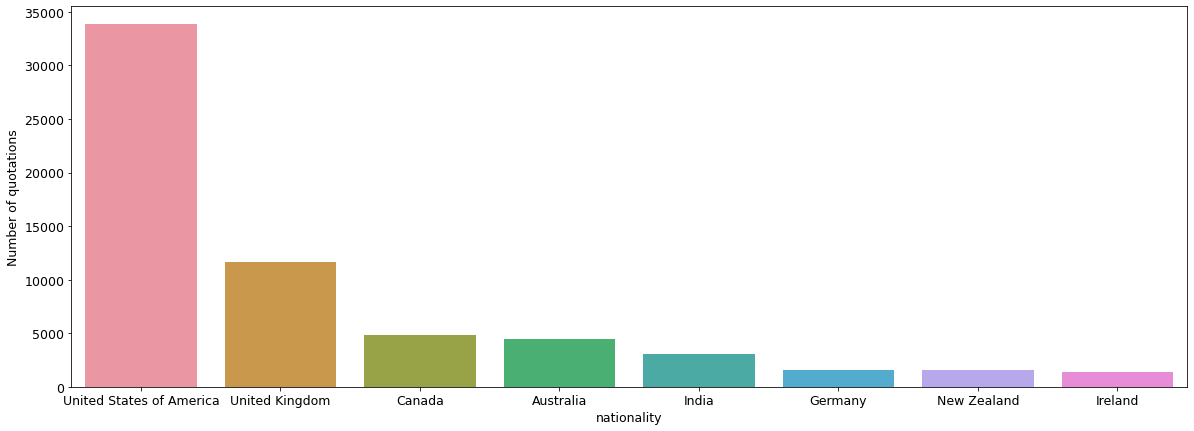

In [16]:
#Distribution of nationality

df_nationality = df_plot.groupby('nationality')['nationality'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
  
df_nationality['nationality'] = df_nationality['nationality'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="nationality", y="count",data=df_nationality[:8])
ax.set(ylabel='Number of quotations')


In [17]:
#df_nationality['fraction'] = df_nationality['count']/df_nationality['count'].sum()*100


In [18]:
df_pie = df_nationality.copy()
df_pie.drop(labels= df_pie[5:].index, axis=0,inplace=True)
new_row = {'nationality': 'Others', 'count': df_nationality[5:]['count'].sum()}
df_pie = df_pie.append(new_row, ignore_index = True)

Text(0.5, 1.0, 'Distribution of speakers nationality')

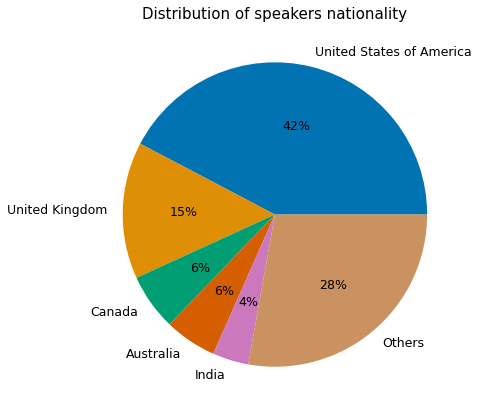

In [19]:
fig, ax = plt.subplots(1,1)
colors = sns.color_palette("colorblind")
ax.pie(x=df_pie['count'],labels=df_pie['nationality'],colors=colors,autopct='%1.f%%',pctdistance=0.6,labeldistance=1.1);
ax.set_title('Distribution of speakers nationality')

In [20]:
path =r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Figures/'
fig.savefig(path+'metadataPlot_nationality_pie.svg',format = 'svg',bbox_inches='tight')
fig.savefig(path+'metadataPlot_nationality_pie.png',format = 'png',bbox_inches='tight')

[Text(0, 0.5, 'Number of quotations')]

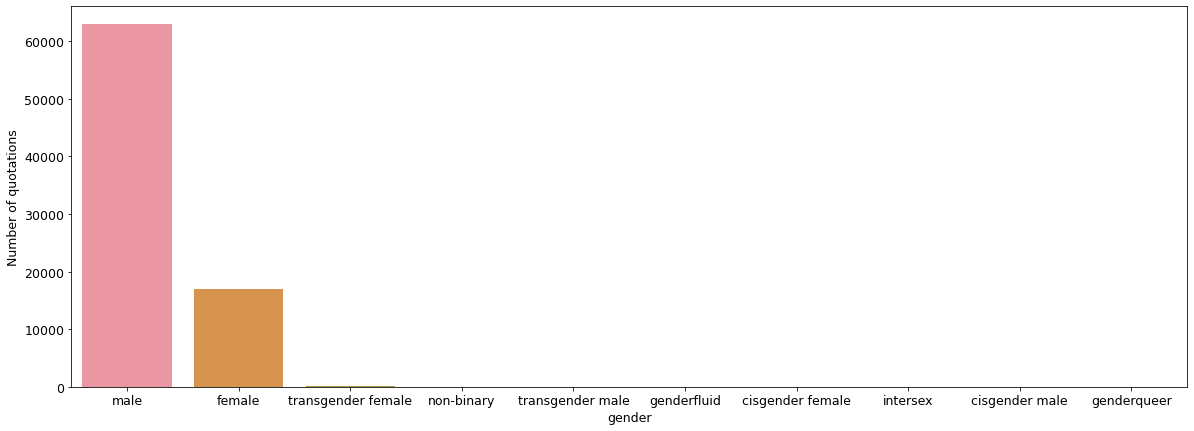

In [21]:
#Distribution of gender per quotation

df_gender = df_plot.groupby('gender')['gender'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
    
df_gender['gender'] = df_gender['gender'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="gender", y="count", data=df_gender[:10])
ax.set(ylabel='Number of quotations')

[Text(0, 0.5, 'Number of quotations')]

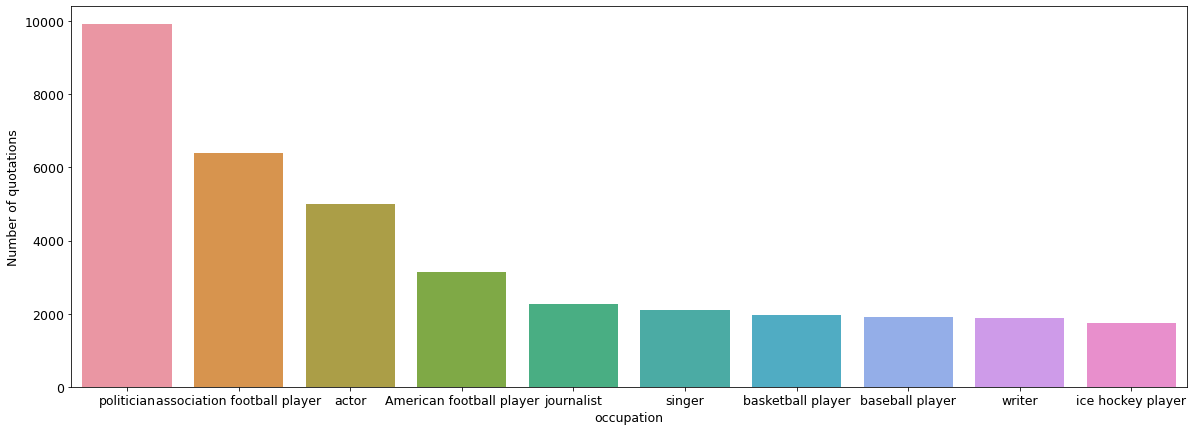

In [22]:
#Distribution of occupation

df_occupation = df_plot.groupby('occupation')['occupation'].count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False)
    
df_occupation['occupation'] = df_occupation['occupation'].apply(lambda x: df_lookup.loc[x]['Label'])
ax = sns.barplot(x="occupation", y="count", data=df_occupation[:10])
ax.set(ylabel='Number of quotations')

In [23]:
df_pie = df_occupation.copy()
df_pie.drop(labels= df_pie[9:].index, axis=0,inplace=True)
new_row = {'occupation': 'Others', 'count': df_nationality[9:]['count'].sum()}
df_pie = df_pie.append(new_row, ignore_index = True)

Text(0.5, 1.0, 'Distribution of speakers occupations')

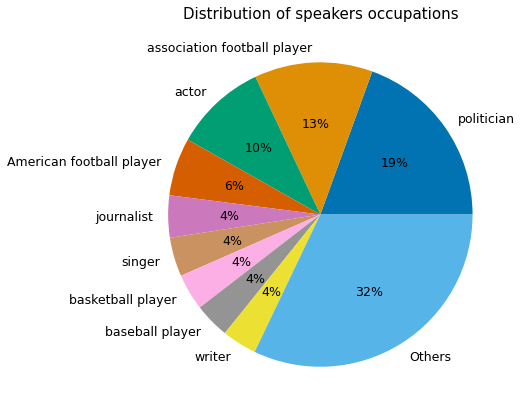

In [163]:
fig, ax = plt.subplots(1,1)
colors = sns.color_palette("colorblind")
ax.pie(x=df_pie['count'],labels=df_pie['occupation'],colors=colors,autopct='%1.f%%',pctdistance=0.6,labeldistance=1.1);
ax.set_title('Distribution of speakers occupations')

In [164]:
path =r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Figures/'
fig.savefig(path+'metadataPlot_occupation_pie.svg',format = 'svg',bbox_inches='tight')
fig.savefig(path+'metadataPlot_occupation_pie.png',format = 'png',bbox_inches='tight')

### Appendix